In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hippocampal-dataset/Task520_HarP/dataset.json
/kaggle/input/hippocampal-dataset/Task520_HarP/labelTr/HarP_077.nii
/kaggle/input/hippocampal-dataset/Task520_HarP/labelTr/HarP_025.nii
/kaggle/input/hippocampal-dataset/Task520_HarP/labelTr/HarP_050.nii
/kaggle/input/hippocampal-dataset/Task520_HarP/labelTr/HarP_027.nii
/kaggle/input/hippocampal-dataset/Task520_HarP/labelTr/HarP_002.nii
/kaggle/input/hippocampal-dataset/Task520_HarP/labelTr/HarP_084.nii
/kaggle/input/hippocampal-dataset/Task520_HarP/labelTr/HarP_078.nii
/kaggle/input/hippocampal-dataset/Task520_HarP/labelTr/HarP_068.nii
/kaggle/input/hippocampal-dataset/Task520_HarP/labelTr/HarP_034.nii
/kaggle/input/hippocampal-dataset/Task520_HarP/labelTr/HarP_122.nii
/kaggle/input/hippocampal-dataset/Task520_HarP/labelTr/HarP_024.nii
/kaggle/input/hippocampal-dataset/Task520_HarP/labelTr/HarP_032.nii
/kaggle/input/hippocampal-dataset/Task520_HarP/labelTr/HarP_011.nii
/kaggle/input/hippocampal-dataset/Task520_HarP/labelTr/H

In [2]:
import numpy as np
import nibabel as nib
import os
from glob import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from scipy.spatial.distance import directed_hausdorff, cdist
from scipy.ndimage import binary_erosion, zoom, label
from scipy.ndimage import binary_opening, binary_closing

DATASET_DIR = '/kaggle/input/hippocampal-dataset/Task520_HarP'

In [3]:
image_path = "/kaggle/input/hippocampal-dataset/Task520_HarP/imageTr/HarP_000.nii"
label_path = "/kaggle/input/hippocampal-dataset/Task520_HarP/labelTr/HarP_000.nii"

img = nib.load(image_path)
lbl = nib.load(label_path)

img_data = img.get_fdata()
lbl_data = lbl.get_fdata()

print("Image Shape:", img_data.shape)
print("Label Shape:", lbl_data.shape)
print("Image Datatype:", img_data.dtype)
print("Label Unique Values:", np.unique(lbl_data))

Image Shape: (64, 64, 96)
Label Shape: (64, 64, 96)
Image Datatype: float64
Label Unique Values: [0. 1.]


In [4]:
image_paths = glob("/kaggle/input/hippocampal-dataset/Task520_HarP/imageTr/*")
# print("Found:", len(image_paths))
# print(image_paths[:5])
all_voxels = []
for img_path in image_paths:
    data = nib.load(img_path).get_fdata()
    all_voxels.append(data.flatten())

all_voxels = np.concatenate(all_voxels)

print("Min:", np.min(all_voxels))
print("Max:", np.max(all_voxels))
print("Mean:", np.mean(all_voxels))
print("Standard Deviation:", np.std(all_voxels))

Min: 0.0
Max: 6834.0
Mean: 577.7217242589195
Standard Deviation: 734.4687348762719


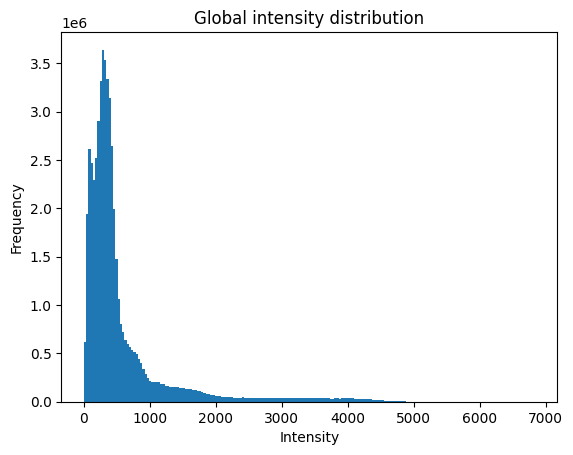

In [5]:
plt.hist(all_voxels, bins=200)
plt.title("Global intensity distribution")
plt.xlabel("Intensity")
plt.ylabel("Frequency")
plt.show()

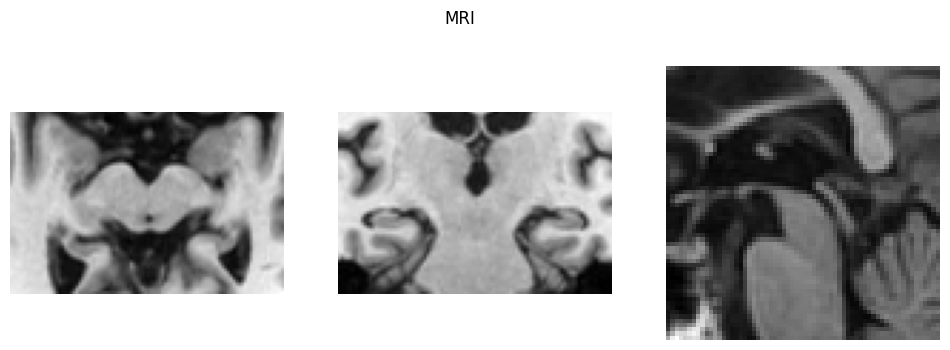

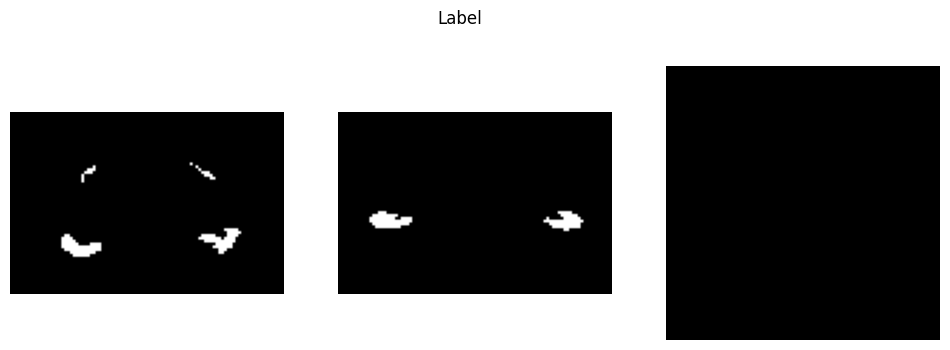

In [6]:
def show_slices(volume, title=""):
    z, y, x = volume.shape
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(volume[z//2, :, :], cmap='gray')
    axes[1].imshow(volume[:, y//2, :], cmap='gray')
    axes[2].imshow(volume[:, :, x//2], cmap='gray')
    for ax in axes:
        ax.axis('off')
    plt.suptitle(title)
    plt.show()

show_slices(img_data, "MRI")
show_slices(lbl_data, "Label")

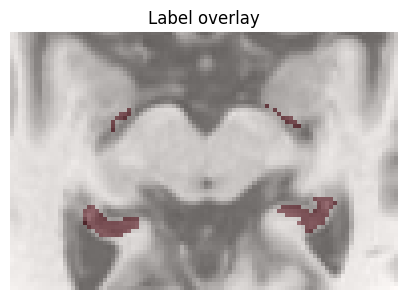

In [7]:
plt.figure(figsize=(5,5))
slice_idx = img_data.shape[0] // 2
plt.imshow(img_data[slice_idx], cmap='gray')
plt.imshow(lbl_data[slice_idx], alpha=0.4, cmap='Reds')
plt.axis('off')
plt.title("Label overlay")
plt.show()

In [8]:
hippo_voxels = np.sum(lbl_data > 0)
total_voxels = lbl_data.size

print("Hippocampus voxels:", hippo_voxels)
print("Background voxels:", total_voxels - hippo_voxels)
print("Ratio:", hippo_voxels / total_voxels)

Hippocampus voxels: 6075
Background voxels: 387141
Ratio: 0.01544952392578125


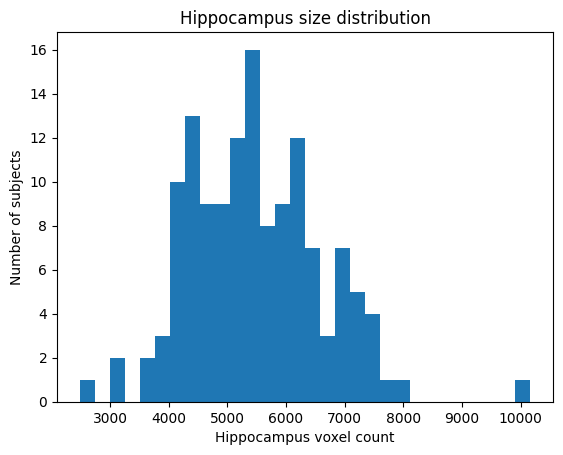

In [9]:
label_paths = glob("/kaggle/input/hippocampal-dataset/Task520_HarP/labelTr/*")
volumes = []

for lbl_path in label_paths:
    lbl = nib.load(lbl_path).get_fdata()
    volumes.append(np.sum(lbl > 0))

plt.hist(volumes, bins=30)
plt.xlabel("Hippocampus voxel count")
plt.ylabel("Number of subjects")
plt.title("Hippocampus size distribution")
plt.show()

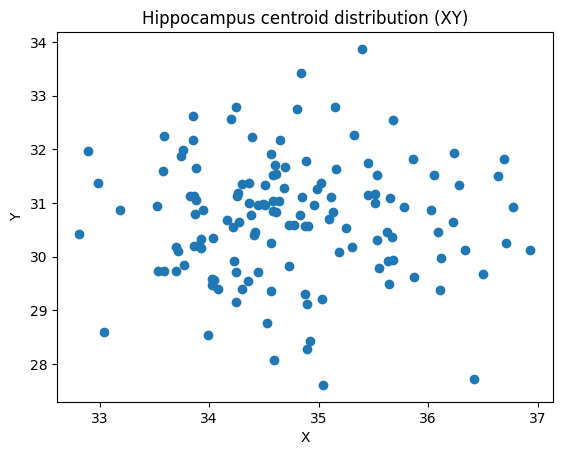

In [10]:
centroids = []

for lbl_path in label_paths:
    lbl = nib.load(lbl_path).get_fdata()
    coords = np.argwhere(lbl > 0)
    centroids.append(coords.mean(axis=0))

centroids = np.array(centroids)

plt.scatter(centroids[:,0], centroids[:,1])
plt.title("Hippocampus centroid distribution (XY)")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [11]:
np.random.shuffle(label_paths)
split = int(0.8 * len(label_paths))
train_label_paths = label_paths[:split]
val_label_paths = label_paths[split:]

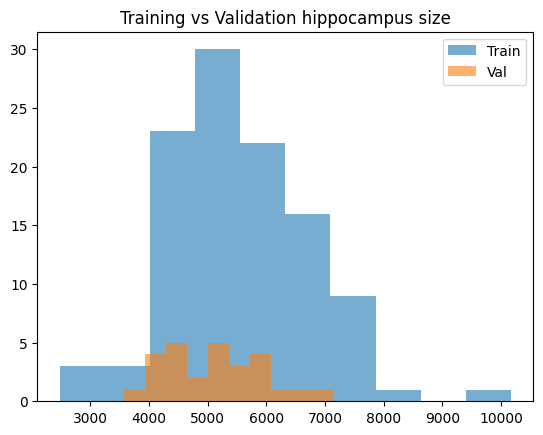

In [12]:
def compute_stats(paths):
    vols = []
    for p in paths:
        lbl = nib.load(p).get_fdata()
        vols.append(np.sum(lbl > 0))
    return np.array(vols)

train_vols = compute_stats(train_label_paths)
val_vols = compute_stats(val_label_paths)

plt.hist(train_vols, alpha=0.6, label="Train")
plt.hist(val_vols, alpha=0.6, label="Val")
plt.legend()
plt.title("Training vs Validation hippocampus size")
plt.show()

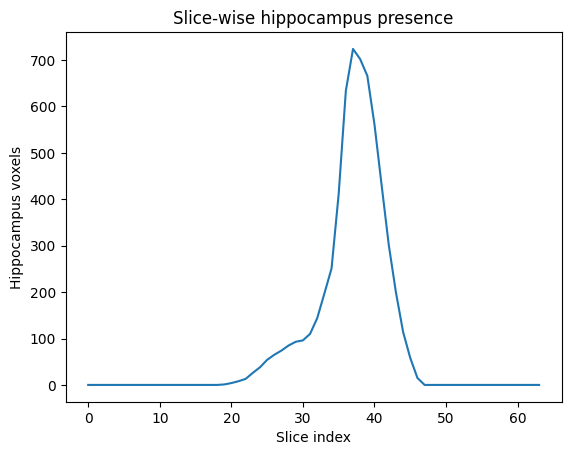

In [13]:
slice_presence = np.sum(lbl_data > 0, axis=(1,2))

plt.plot(slice_presence)
plt.xlabel("Slice index")
plt.ylabel("Hippocampus voxels")
plt.title("Slice-wise hippocampus presence")
plt.show()

In [14]:
img = nib.load(image_paths[0])
print(img.header.get_zooms())

(np.float32(1.0), np.float32(1.0), np.float32(1.0))


In [15]:
print(img.header.get_qform())
print(img.header.get_sform())

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [16]:
np.unique(nib.load(label_paths[0]).get_fdata())

array([0., 1.])

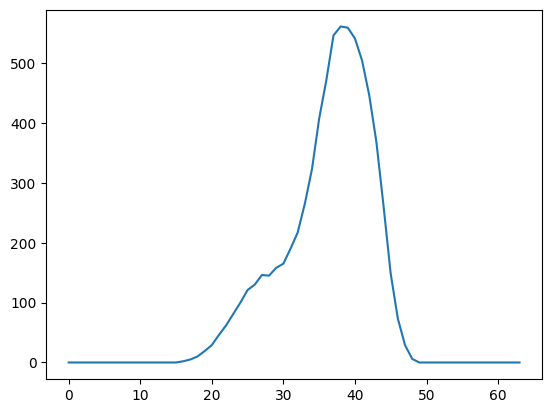

In [17]:
lbl = nib.load(label_paths[0]).get_fdata()
presence = np.sum(lbl > 0, axis=(1,2))
plt.plot(presence)

In [18]:
vol = np.array(volumes)
outliers = np.where(vol > vol.mean() + 3*vol.std())[0]
outliers

array([97])

In [19]:
boxes = []
for p in label_paths:
    lbl = nib.load(p).get_fdata()
    c = np.argwhere(lbl > 0)
    boxes.append(c.max(axis=0) - c.min(axis=0))

boxes = np.array(boxes)
boxes.mean(axis=0)

array([28.99259259, 38.56296296, 69.00740741])

In [20]:
image_paths

['/kaggle/input/hippocampal-dataset/Task520_HarP/imageTr/HarP_077.nii',
 '/kaggle/input/hippocampal-dataset/Task520_HarP/imageTr/HarP_025.nii',
 '/kaggle/input/hippocampal-dataset/Task520_HarP/imageTr/HarP_050.nii',
 '/kaggle/input/hippocampal-dataset/Task520_HarP/imageTr/HarP_027.nii',
 '/kaggle/input/hippocampal-dataset/Task520_HarP/imageTr/HarP_002.nii',
 '/kaggle/input/hippocampal-dataset/Task520_HarP/imageTr/HarP_084.nii',
 '/kaggle/input/hippocampal-dataset/Task520_HarP/imageTr/HarP_078.nii',
 '/kaggle/input/hippocampal-dataset/Task520_HarP/imageTr/HarP_068.nii',
 '/kaggle/input/hippocampal-dataset/Task520_HarP/imageTr/HarP_034.nii',
 '/kaggle/input/hippocampal-dataset/Task520_HarP/imageTr/HarP_122.nii',
 '/kaggle/input/hippocampal-dataset/Task520_HarP/imageTr/HarP_024.nii',
 '/kaggle/input/hippocampal-dataset/Task520_HarP/imageTr/HarP_032.nii',
 '/kaggle/input/hippocampal-dataset/Task520_HarP/imageTr/HarP_011.nii',
 '/kaggle/input/hippocampal-dataset/Task520_HarP/imageTr/HarP_04

In [21]:
label_paths

['/kaggle/input/hippocampal-dataset/Task520_HarP/labelTr/HarP_088.nii',
 '/kaggle/input/hippocampal-dataset/Task520_HarP/labelTr/HarP_078.nii',
 '/kaggle/input/hippocampal-dataset/Task520_HarP/labelTr/HarP_028.nii',
 '/kaggle/input/hippocampal-dataset/Task520_HarP/labelTr/HarP_020.nii',
 '/kaggle/input/hippocampal-dataset/Task520_HarP/labelTr/HarP_092.nii',
 '/kaggle/input/hippocampal-dataset/Task520_HarP/labelTr/HarP_035.nii',
 '/kaggle/input/hippocampal-dataset/Task520_HarP/labelTr/HarP_104.nii',
 '/kaggle/input/hippocampal-dataset/Task520_HarP/labelTr/HarP_055.nii',
 '/kaggle/input/hippocampal-dataset/Task520_HarP/labelTr/HarP_082.nii',
 '/kaggle/input/hippocampal-dataset/Task520_HarP/labelTr/HarP_031.nii',
 '/kaggle/input/hippocampal-dataset/Task520_HarP/labelTr/HarP_009.nii',
 '/kaggle/input/hippocampal-dataset/Task520_HarP/labelTr/HarP_101.nii',
 '/kaggle/input/hippocampal-dataset/Task520_HarP/labelTr/HarP_039.nii',
 '/kaggle/input/hippocampal-dataset/Task520_HarP/labelTr/HarP_02

In [22]:
idx = np.arange(len(image_paths))
np.random.seed(42)
np.random.shuffle(idx)

split = int(0.8 * len(idx))

train_idx = idx[:split]
val_idx   = idx[split:]

train_images = [image_paths[i] for i in train_idx]
train_labels = [label_paths[i] for i in train_idx]

val_images = [image_paths[i] for i in val_idx]
val_labels = [label_paths[i] for i in val_idx]


In [23]:
def normalize(img):
    return (img - img.mean()) / (img.std() + 1e-8)

In [24]:
class HarP2DDataset(Dataset):
    def __init__(self, image_paths, label_paths):
        self.samples = []

        for img_p, lbl_p in zip(image_paths, label_paths):
            img = normalize(nib.load(img_p).get_fdata())
            lbl = nib.load(lbl_p).get_fdata()

            for z in range(img.shape[0]):
                if np.sum(lbl[z] > 0) > 0:   # keep useful slices only
                    self.samples.append((img[z], lbl[z]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img, lbl = self.samples[idx]
        return (
            torch.tensor(img).unsqueeze(0).float(),
            torch.tensor(lbl > 0).unsqueeze(0).float()
        )


In [25]:
train_ds = HarP2DDataset(train_images, train_labels)
val_ds   = HarP2DDataset(val_images, val_labels)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=8)


In [26]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[32, 64, 128, 256]):
        super().__init__()

        self.encoders = nn.ModuleList()
        self.decoders = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder blocks
        for feature in features:
            self.encoders.append(self.double_conv(in_channels, feature))
            in_channels = feature

        # Bottleneck
        self.bottleneck = self.double_conv(features[-1], features[-1]*2)

        # Decoder blocks
        for feature in reversed(features):
            self.decoders.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.decoders.append(self.double_conv(feature*2, feature))

        # Final output layer
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def double_conv(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        skip_connections = []

        # Encoder path
        for enc in self.encoders:
            x = enc(x)
            skip_connections.append(x)
            x = self.pool(x)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder path
        skip_connections = skip_connections[::-1]
        for idx in range(0, len(self.decoders), 2):
            x = self.decoders[idx](x)  # ConvTranspose (upsample)
            skip_conn = skip_connections[idx//2]
            # In case of mismatched sizes due to pooling
            if x.shape != skip_conn.shape:
                x = F.interpolate(x, size=skip_conn.shape[2:])
            x = torch.cat((skip_conn, x), dim=1)  # concatenate skip connection
            x = self.decoders[idx+1](x)  # double conv

        return self.final_conv(x)

In [27]:
def dice_loss(pred, target):
    pred = torch.sigmoid(pred)
    smooth = 1e-5
    inter = (pred * target).sum()
    return 1 - (2*inter + smooth) / (pred.sum() + target.sum() + smooth)

In [28]:
def hd95(pred_mask, gt_mask):
    """
    Compute 3D Hausdorff distance between predicted and ground truth masks.
    Both masks are binary numpy arrays of same shape.
    """
    # Get coordinates of non-zero voxels (hippocampus)
    pred_points = np.argwhere(pred_mask > 0)
    gt_points = np.argwhere(gt_mask > 0)

    if len(pred_points) == 0 or len(gt_points) == 0:
        # Empty mask → return large distance
        return np.nan

    # pairwise distance
    d_matrix = cdist(pred_points, gt_points)

    # Directed Hausdorff distances
    d_pred_to_gt = d_matrix.min(axis=1)
    d_gt_to_pred = d_matrix.min(axis=0)
    
    # 95th percentile
    hd95_val = np.percentile(np.concatenate([d_pred_to_gt, d_gt_to_pred]), 95)
    return hd95_val

In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = int(input("Enter how many Epochs should happen: "))

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        opt.zero_grad()
        pred = model(x) 
        loss = dice_loss(pred, y)
        loss.backward()
        opt.step()
        train_loss += loss.item()

        # Compute Hausdorff for **each sample in the batch**
        pred_sig = torch.sigmoid(pred).detach().cpu().numpy()  # [B, 1, H, W]
        y_np = y.cpu().numpy()                        # [B, 1, H, W]
        
        for b in range(pred_sig.shape[0]):
            pred_mask = (pred_sig[b,0] > 0.5).astype(np.uint8)
            gt_mask = (y_np[b,0] > 0.5).astype(np.uint8)
            hd_val = hd95(pred_mask, gt_mask)

    print(f"Epoch {epoch+1:03d} | Train Dice Loss: {train_loss/len(train_loader):.4f} | Hausdorff Distance (HD95): {hd_val:.4f} mm")

Enter how many Epochs should happen:  200


Epoch 001 | Train Dice Loss: 0.6588 | Hausdorff Distance (HD95): 6.4031 mm
Epoch 002 | Train Dice Loss: 0.4883 | Hausdorff Distance (HD95): 2.2361 mm
Epoch 003 | Train Dice Loss: 0.4626 | Hausdorff Distance (HD95): 5.0347 mm
Epoch 004 | Train Dice Loss: 0.4466 | Hausdorff Distance (HD95): nan mm
Epoch 005 | Train Dice Loss: 0.4309 | Hausdorff Distance (HD95): 3.6056 mm
Epoch 006 | Train Dice Loss: 0.4085 | Hausdorff Distance (HD95): 6.0497 mm
Epoch 007 | Train Dice Loss: 0.3860 | Hausdorff Distance (HD95): 3.6056 mm
Epoch 008 | Train Dice Loss: 0.3629 | Hausdorff Distance (HD95): 9.0277 mm
Epoch 009 | Train Dice Loss: 0.3452 | Hausdorff Distance (HD95): 3.6056 mm
Epoch 010 | Train Dice Loss: 0.3235 | Hausdorff Distance (HD95): 2.8284 mm
Epoch 011 | Train Dice Loss: 0.3046 | Hausdorff Distance (HD95): 2.8284 mm
Epoch 012 | Train Dice Loss: 0.2914 | Hausdorff Distance (HD95): 3.0000 mm
Epoch 013 | Train Dice Loss: 0.2744 | Hausdorff Distance (HD95): 5.0000 mm
Epoch 014 | Train Dice Loss:

In [30]:
torch.save(model.state_dict(), "/kaggle/working/unet2d.pth")

In [31]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = UNet().to(device)
model.load_state_dict(torch.load("/kaggle/working/unet2d.pth", map_location=device))
model.eval()

UNet(
  (encoders): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(1

In [32]:
def infer_volume(model, image_path):
    img = nib.load(image_path)
    img_data = img.get_fdata()
    img_norm = normalize(img_data)

    pred_mask = np.zeros_like(img_data)

    with torch.no_grad():
        for z in range(img_data.shape[0]):
            slice_img = img_norm[z]
            inp = torch.tensor(slice_img).unsqueeze(0).unsqueeze(0).float().to(device)

            pred = model(inp)
            pred = torch.sigmoid(pred).cpu().numpy()[0,0]
            pred_mask[z] = (pred > 0.5).astype(np.uint8)

    return pred_mask, img.affine

In [33]:
def save_mask(mask, affine, out_path):
    nib.save(nib.Nifti1Image(mask, affine), out_path)

In [34]:
os.makedirs("/kaggle/working/pred_masks", exist_ok=True)

for img_path in val_images:
    mask, affine = infer_volume(model, img_path)
    fname = os.path.basename(img_path)
    save_mask(mask, affine, f"/kaggle/working/pred_masks/{fname}")

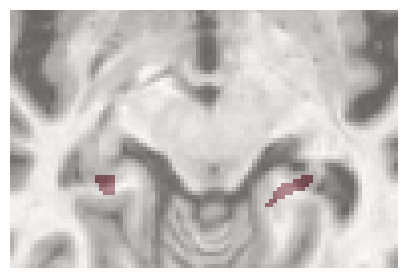

In [35]:
mask, _ = infer_volume(model, val_images[0])
slice_idx = mask.shape[0] // 2

plt.figure(figsize=(5,5))
plt.imshow(nib.load(val_images[0]).get_fdata()[slice_idx], cmap="gray")
plt.imshow(mask[slice_idx], alpha=0.4, cmap="Reds")
plt.axis("off")
plt.show()

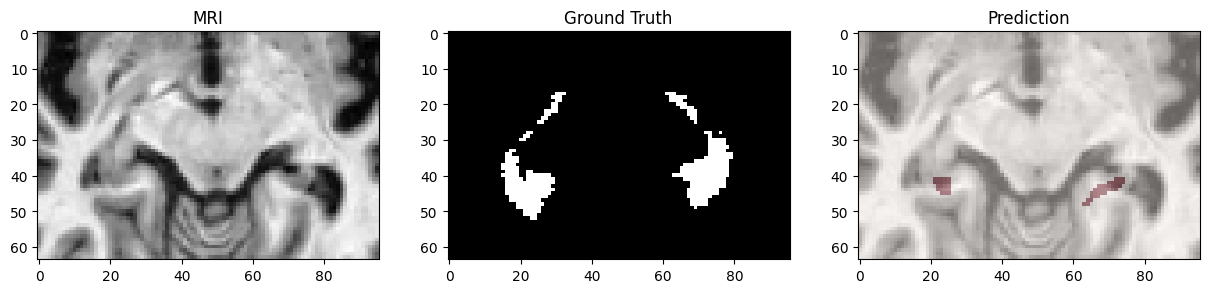

In [36]:
img = nib.load(val_images[0]).get_fdata()
lbl = nib.load(val_labels[0]).get_fdata()

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(img[slice_idx], cmap="gray")
plt.title("MRI")

plt.subplot(1,3,2)
plt.imshow(lbl[slice_idx], cmap="gray")
plt.title("Ground Truth")

plt.subplot(1,3,3)
plt.imshow(img[slice_idx], cmap="gray")
plt.imshow(mask[slice_idx], alpha=0.4, cmap="Reds")
plt.title("Prediction")

plt.show()

In [37]:
dice_list = []

for img_path, lbl_path in zip(val_images, val_labels):
    pred_mask, _ = infer_volume(model, img_path)
    gt_mask = nib.load(lbl_path).get_fdata() > 0
    
    # Convert to torch tensors
    pred_mask = torch.tensor(pred_mask, dtype=torch.float32)
    gt_mask = torch.tensor(gt_mask, dtype=torch.float32)

    dice = dice_loss(pred_mask, gt_mask).item()
    dice_list.append(dice_loss(pred_mask, gt_mask))

print("Mean Dice on Validation Set:", np.mean(dice_list))

Mean Dice on Validation Set: 0.9669456


In [38]:
hd95_list  = []

for img_path, lbl_path in zip(val_images, val_labels):
    pred_mask, _ = infer_volume(model, img_path)
    gt_mask = nib.load(lbl_path).get_fdata() > 0

    hd_val = hd95(pred_mask, gt_mask)
    hd95_list.append(hd_val)

print("Mean Hausdorff Distance (HD95) on Validation Set:", np.nanmean(hd95_list), "mm")

Mean Hausdorff Distance (HD95) on Validation Set: 6.6386704167485036 mm


In [39]:
for i, (d, hd) in enumerate(zip(dice_list, hd95_list)):
    print(f"Subject {i}: Dice = {d:.4f} | Hausdorff Distance (HD95) = {hd:.4f} mm")

Subject 0: Dice = 0.9647 | Hausdorff Distance (HD95) = 4.1231 mm
Subject 1: Dice = 0.9736 | Hausdorff Distance (HD95) = 6.4419 mm
Subject 2: Dice = 0.9641 | Hausdorff Distance (HD95) = 4.5826 mm
Subject 3: Dice = 0.9667 | Hausdorff Distance (HD95) = 4.0000 mm
Subject 4: Dice = 0.9671 | Hausdorff Distance (HD95) = 21.7278 mm
Subject 5: Dice = 0.9631 | Hausdorff Distance (HD95) = 3.0000 mm
Subject 6: Dice = 0.9699 | Hausdorff Distance (HD95) = 11.7750 mm
Subject 7: Dice = 0.9618 | Hausdorff Distance (HD95) = 5.7226 mm
Subject 8: Dice = 0.9587 | Hausdorff Distance (HD95) = 16.1183 mm
Subject 9: Dice = 0.9716 | Hausdorff Distance (HD95) = 5.0000 mm
Subject 10: Dice = 0.9431 | Hausdorff Distance (HD95) = 5.1962 mm
Subject 11: Dice = 0.9625 | Hausdorff Distance (HD95) = 3.1623 mm
Subject 12: Dice = 0.9747 | Hausdorff Distance (HD95) = 4.0000 mm
Subject 13: Dice = 0.9700 | Hausdorff Distance (HD95) = 5.7446 mm
Subject 14: Dice = 0.9695 | Hausdorff Distance (HD95) = 5.7446 mm
Subject 15: Dice 

In [40]:
print("Pred shape:", pred_mask.shape)
print("GT shape:", gt_mask.shape)

Pred shape: (64, 64, 96)
GT shape: (64, 64, 96)
